## Import lib

In [1]:
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, random_split

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

device = ("cuda" if torch.cuda.is_available() else "cpu")

## Data
Load the csv files and view some of the data

In [2]:
train_file = os.path.join('../input/gtsrb-german-traffic-sign/Train.csv')
test_file = os.path.join('../input/gtsrb-german-traffic-sign/Test.csv')

In [3]:
df_train = pd.read_csv(train_file)
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
df_test = pd.read_csv(test_file)
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
print(f'Train csv shape: {df_train.shape} \nTest csv shape: {df_test.shape}')

Train csv shape: (39209, 8) 
Test csv shape: (12630, 8)


## Data distribution
Displaying a bar chart which shows the sample of class occurences within the dataset.

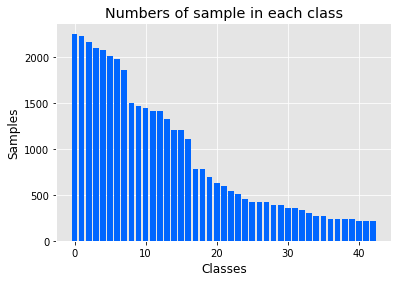

In [6]:
c = df_train['ClassId'].nunique()
x = df_train['ClassId'].value_counts()

plt.bar(x=x.index.sort_values(), height=x, color='#0066ff')
plt.title('Numbers of sample in each class', color='black')
plt.xlabel("Classes", color='black')
plt.ylabel("Samples", color='black')
plt.tick_params(colors='black')

## Custom Dataset
Create a custom dataset class with the proper methods for importing the data

In [7]:
class GTSRBDataset(Dataset):
    def __init__(self, image_info, target_shape=(32, 32)):
        self.target_height = target_shape[0]
        self.target_width = target_shape[1]

        # read data 
        self.images_path, self.labels, self.nSample = self.read_label_data(image_info)

    def read_label_data(self, image_info):
        # load labels data
        images_path = []
        labels = []
        number_data = 0
        
        # read label data from csv file
        image_data = pd.read_csv(image_info)
        
        for index, data in image_data.iterrows():
            images_path.append('../input/gtsrb-german-traffic-sign/' + data['Path'])
            labels.append(data['ClassId'])
            number_data += 1
        
        return images_path, labels, number_data

    def read_image(self, img_path):
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.target_width, self.target_height), cv2.INTER_CUBIC)
        img = img.transpose(2, 0, 1)
        img = img / 255.0

        return img

    def __getitem__(self, idx):
        img_path = self.images_path[idx]
        label = self.labels[idx]
        img = self.read_image(img_path)

        return (img, label)

    def __len__(self):
        return self.nSample

    def visualize_random_images(self, nb_row=2, nb_col=3):
        fig, axes = plt.subplots(nb_row,nb_col, figsize=(18, 18))

        for i,ax in enumerate(axes.flat):
            r = np.random.randint(self.nSample)
            img = cv2.imread(self.images_path[r])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.grid(False)
            ax.axis('off')
            ax.set_title('Label: '+ str(self.labels[r]))


class Collator(object):
    def __call__(self, batch):
        images = []
        labels = []

        for sample in batch:
            img, label = sample
            
            if img is None:
                continue
            images.append(img)
            labels.append(label)

        return torch.FloatTensor(images), torch.LongTensor(labels)

## Create Dataset

In [8]:
dataset = GTSRBDataset(image_info='../input/gtsrb-german-traffic-sign/Train.csv', target_shape=(32, 32))
nb_classes = len(np.unique(dataset.labels))
print('The number of data: {} \nThe number of classes: {}'.format(len(dataset), nb_classes))

The number of data: 39209 
The number of classes: 43


## Split train and val dataloader

In [9]:
split_ratio = 0.8
n_train = int(len(dataset) * split_ratio)
n_val = len(dataset) - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

print("The number of train data: ", len(train_dataset))
print("The number of val data: ", len(val_dataset))

The number of train data:  31367
The number of val data:  7842


## Create model

In [10]:
# Create se_block
class SEBlock(nn.Module):

    def __init__(self, input_channels, internal_neurons):
        super(SEBlock, self).__init__()
        self.down = nn.Conv2d(in_channels=input_channels, out_channels=internal_neurons, kernel_size=1, stride=1, bias=True)
        self.up = nn.Conv2d(in_channels=internal_neurons, out_channels=input_channels, kernel_size=1, stride=1, bias=True)
        self.input_channels = input_channels

    def forward(self, inputs):
        x = F.avg_pool2d(inputs, kernel_size=inputs.size(3))
        x = self.down(x)
        x = F.relu(x)
        x = self.up(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.input_channels, 1, 1)
        
        return inputs * x

In [11]:
# Create repvgg_block
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if use_se:
            self.se = SEBlock(out_channels, internal_neurons=out_channels // 16)
        else:
            self.se = nn.Identity()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            # print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.se(self.rbr_reparam(inputs)))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.se(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out))

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])


    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0

        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
            
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def switch_to_deploy(self):
        if hasattr(self, 'rbr_reparam'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.rbr_reparam = nn.Conv2d(in_channels=self.rbr_dense.conv.in_channels, out_channels=self.rbr_dense.conv.out_channels,
                                     kernel_size=self.rbr_dense.conv.kernel_size, stride=self.rbr_dense.conv.stride,
                                     padding=self.rbr_dense.conv.padding, dilation=self.rbr_dense.conv.dilation, groups=self.rbr_dense.conv.groups, bias=True)
        self.rbr_reparam.weight.data = kernel
        self.rbr_reparam.bias.data = bias
        for para in self.parameters():
            para.detach_()
        self.__delattr__('rbr_dense')
        self.__delattr__('rbr_1x1')
        if hasattr(self, 'rbr_identity'):
            self.__delattr__('rbr_identity')

In [12]:
# Create repvgg model
class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()
        self.use_se = use_se

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy, use_se=self.use_se)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def create_RepVGG_A0(num_classes, deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_classes, width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

In [13]:
repvgg_model = create_RepVGG_A0(num_classes=nb_classes)
repvgg_model = repvgg_model.to(device)

## Define config

In [14]:
batch_size = 128
valid_every = 2000
print_every = 500
lr = 0.001
num_iters = 12000

## Create dataloader for loading data

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=Collator(), shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=Collator(), shuffle=False, num_workers=2, pin_memory=True, drop_last=True)
data_iter = iter(train_loader)

## Define a loss function and optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(repvgg_model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-09)
scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=num_iters, pct_start=0.1)

## Train model

In [17]:
def batch_to_device(images, gts):
    images = images.to(device, non_blocking=True)
    gts = gts.to(device, non_blocking=True)
    
    return images, gts

In [18]:
def cal_acc(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
def validate():
    repvgg_model.eval()
    total_loss = []
    total_acc = []
    
    with torch.no_grad():
        for batch in val_loader:
            images, gts = batch
            images, gts = batch_to_device(images, gts)
            outputs = repvgg_model(images)
            loss = criterion(outputs, gts)
            acc = cal_acc(outputs, gts)
            
            total_loss.append(loss.item())
            total_acc.append(acc)
            
            del outputs
            del loss
            
    val_loss = np.mean(total_loss)
    val_acc = np.mean(total_acc)
    repvgg_model.train()
    
    return val_loss, val_acc

In [20]:
def train_step(batch):
    # get the inputs
    images, gts = batch
    images, gts = batch_to_device(images, gts)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize + scheduler
    outputs = repvgg_model(images)
    loss = criterion(outputs, gts)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(repvgg_model.parameters(), 1) 
    optimizer.step()
    scheduler.step()

    loss_item = loss.item()
    
    return loss_item

In [21]:
total_loss = 0
best_acc = 0
global_step = 0
weight_path = 'repvgg.pth.tar'

torch.backends.cudnn.benchmark = True

for i in range(num_iters):
    repvgg_model.train()
    
    try:
        batch = next(data_iter)
    except StopIteration:
        data_iter = iter(train_loader)
        batch = next(data_iter)
        
    global_step += 1
    loss = train_step(batch)
    total_loss += loss

    if global_step % print_every == 0:
        print('step: {:06d}, train_loss: {:.4f}'.format(global_step, total_loss / print_every))
        total_loss = 0
        
    if global_step % valid_every == 0:
        # validate 
        val_loss, val_acc = validate()
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(repvgg_model.state_dict(), weight_path)
            
        print("==============================================================================")
        print("val_loss: {:.4f}, val_acc: {:.4f}".format(val_loss, val_acc))
        print("==============================================================================")

step: 000500, train_loss: 1.9706
step: 001000, train_loss: 0.3966
step: 001500, train_loss: 0.1764
step: 002000, train_loss: 0.0932
val_loss: 0.1052, val_acc: 0.9739
step: 002500, train_loss: 0.0694
step: 003000, train_loss: 0.0652
step: 003500, train_loss: 0.0249
step: 004000, train_loss: 0.0232
val_loss: 0.0541, val_acc: 0.9873
step: 004500, train_loss: 0.0262
step: 005000, train_loss: 0.0172
step: 005500, train_loss: 0.0217
step: 006000, train_loss: 0.0227
val_loss: 0.0401, val_acc: 0.9917
step: 006500, train_loss: 0.0372
step: 007000, train_loss: 0.0166
step: 007500, train_loss: 0.0130
step: 008000, train_loss: 0.0114
val_loss: 0.0379, val_acc: 0.9942
step: 008500, train_loss: 0.0270
step: 009000, train_loss: 0.0014
step: 009500, train_loss: 0.0013
step: 010000, train_loss: 0.0147
val_loss: 0.0436, val_acc: 0.9941
step: 010500, train_loss: 0.0027
step: 011000, train_loss: 0.0113
step: 011500, train_loss: 0.0009
step: 012000, train_loss: 0.0108
val_loss: 0.0433, val_acc: 0.9942


## Convert the training-time models into inference-time

In [22]:
def repvgg_model_convert(model:torch.nn.Module, save_path=None, do_copy=True):
    if do_copy:
        model = copy.deepcopy(model)
    for module in model.modules():
        if hasattr(module, 'switch_to_deploy'):
            module.switch_to_deploy()
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
    return model
    
    
# weight path
weight_path = 'repvgg.pth.tar'
convert_weight_path = 'convert_weight_path.pth.tar'

# create model
repvgg_model = create_RepVGG_A0(num_classes=43)
repvgg_model.load_state_dict(torch.load(weight_path, map_location=device), strict=False)

# convert multi branch model to single branch model
convert_model = repvgg_model_convert(repvgg_model, save_path=convert_weight_path)
convert_model = convert_model.to(device)

## Check model in test dataset

In [23]:
def predict(model, images, device):
    images = images.to(device, non_blocking=True)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    
    return preds

In [24]:
# Number of image predict true
lst_wrong_img = []
tp = 0

for index, data in df_test.iterrows():
    img = cv2.imread('../input/gtsrb-german-traffic-sign/' + data['Path'])
    
    preprocess_img = cv2.resize(img, (32, 32), cv2.INTER_AREA)
    preprocess_img = preprocess_img.transpose(2, 0, 1)
    preprocess_img = preprocess_img / 255.0
    preprocess_img = np.expand_dims(preprocess_img, axis=0)
    preprocess_img = torch.FloatTensor(preprocess_img)
    
    output = predict(convert_model, preprocess_img, device)
    output = output.cpu().detach().numpy()
    
    if(int(output[0]) == data['ClassId']):
        tp += 1
    else:
        lst_wrong_img.append([data['Path'], data['ClassId'], int(output[0])])

df = pd.DataFrame(lst_wrong_img, columns = ['Path', 'ClassId', 'Predict'])
df.to_csv('list_wrong_imgs.csv', index=False)

print("Accuracy in test dataset: ", float(tp/df_test.shape[0])*100)

Accuracy in test dataset:  94.9089469517023
